# Introduction of time series forecasting with [`sktime`](https://github.com/alan-turing-institute/sktime)



Main source: [`sktime` documentation](https://www.sktime.org/en/stable/index.html).

Author: Adelson de Araujo (a.dearaujo@utwente.nl)

## Imports

In [1]:
! pip install sktime --quiet
! pip install pmdarima --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sktime

## Load some data

In [3]:
# load some data

from sktime.datasets import load_macroeconomic, load_shampoo_sales, load_airline

Y = load_macroeconomic()
print(type(Y), type(Y.index))
Y.tail()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.indexes.period.PeriodIndex'>


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
Period,,,,,,,,,,,,
2008Q3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008Q4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009Q1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009Q2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
2009Q3,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


<AxesSubplot:ylabel='infl'>

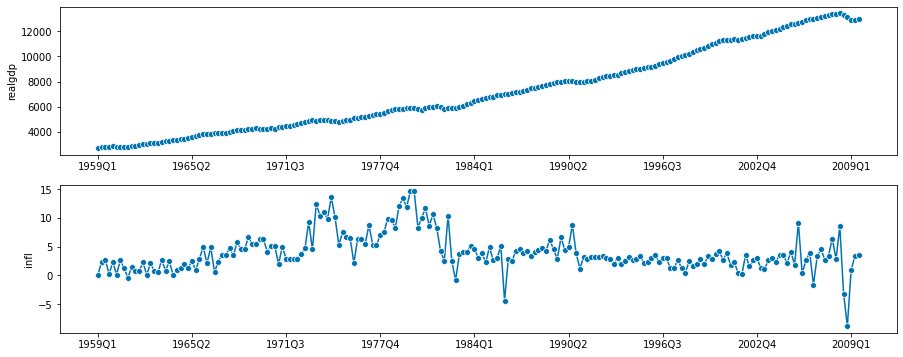

In [4]:
from sktime.utils.plotting import plot_series

realgdp = Y['realgdp']
infl = Y['infl']

fig, ax = plt.subplots(nrows=2, figsize=(15,6))

plot_series(realgdp, ax=ax[0])
plot_series(infl, ax=ax[1])

## Interpolation vs Regression vs Forecasting

### Interpolation

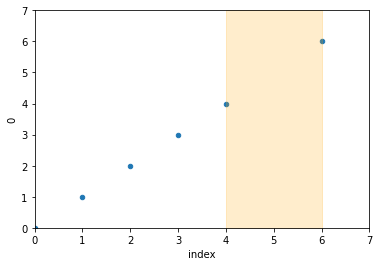

In [5]:
# More info on methods: https://docs.scipy.org/doc/scipy/reference/interpolate.html#univariate-interpolation

import pandas as pd

s = pd.Series([0, 1, 2, 3, 4,  np.nan,  6])
ax = s.reset_index().plot.scatter(x='index', y=0)

ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.fill_between([4,6], [7,7], alpha=0.2, color='orange');

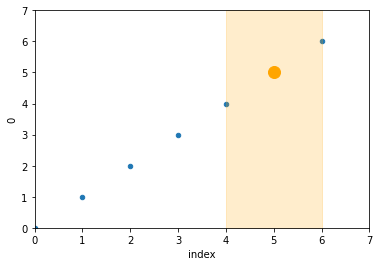

In [6]:
# An intuitive interpolation

s_interp = s.interpolate(method='linear')

ax = s_interp.reset_index().plot.scatter(x='index', y=0)
s_interp[[5]].plot(color='orange', marker='o', markersize=12, ax=ax)
ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.fill_between([4,6], [7,7], alpha=0.2, color='orange')

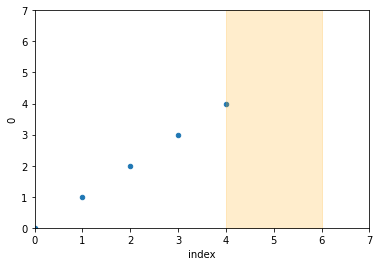

In [7]:
# Forecasting == forward Extrapolation? 

s = pd.Series([0, 1, 2, 3, 4,  np.nan])

ax = s.reset_index().plot.scatter(x='index', y=0)
ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.fill_between([4,6], [7,7], alpha=0.2, color='orange');

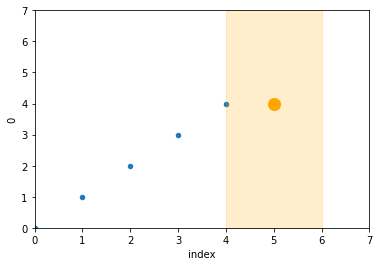

In [8]:
# Linear, limiting direction of neighbor information

s_interp = s.interpolate(method='linear', limit_direction='forward')

ax = s_interp.reset_index().plot.scatter(x='index', y=0)
s_interp[[5]].plot(color='orange', marker='o', markersize=12, ax=ax)
ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.fill_between([4,6], [7,7], alpha=0.2, color='orange');

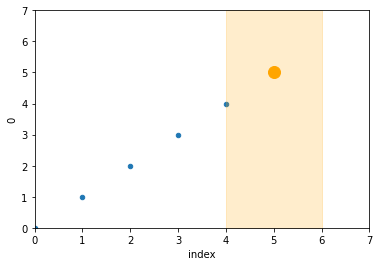

In [9]:
# Spline order 1, limiting direction of neighbor information

s_interp = s.interpolate(method='spline', order=1, limit_direction='forward')

ax = s_interp.reset_index().plot.scatter(x='index', y=0)
s_interp[[5]].plot(color='orange', marker='o', markersize=12, ax=ax)
ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.fill_between([4,6], [7,7], alpha=0.2, color='orange');

### Regression

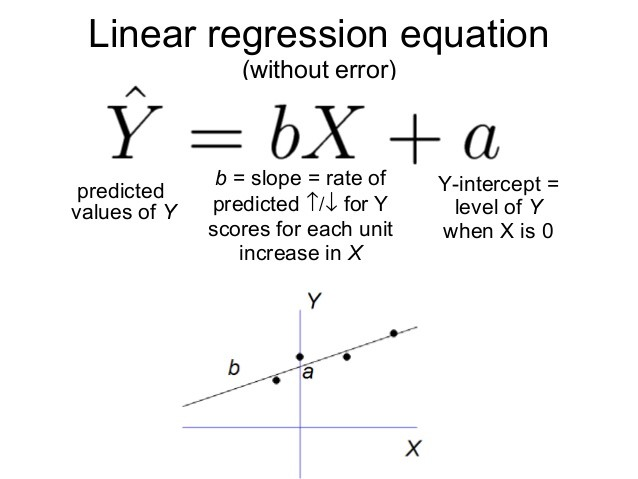

Regression for time series involves finding/designing a good feature set ($X$) that predicts our target values ($Y$). This process is known in machine learning as feature engineering.

```
# ts -> FeatureExtraction -> X (features)
X = FeatureExtraction.fit_transform(ts) # backwards information or not!
```

Lots of algorithms are widely used in the context of time series, including Linear Regression and tree-based ensembles such as Random Forest or Gradient Boosting.

```
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sktime.forecasting.model_selection import temporal_train_test_split

# X, y
X_train, X_test, y_train, y_test = train_test_split(X, y)

regressor = make_pipeline(
    # FeatureExtraction
    RandomForestRegressor(),
)
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)
```



### Forecasting

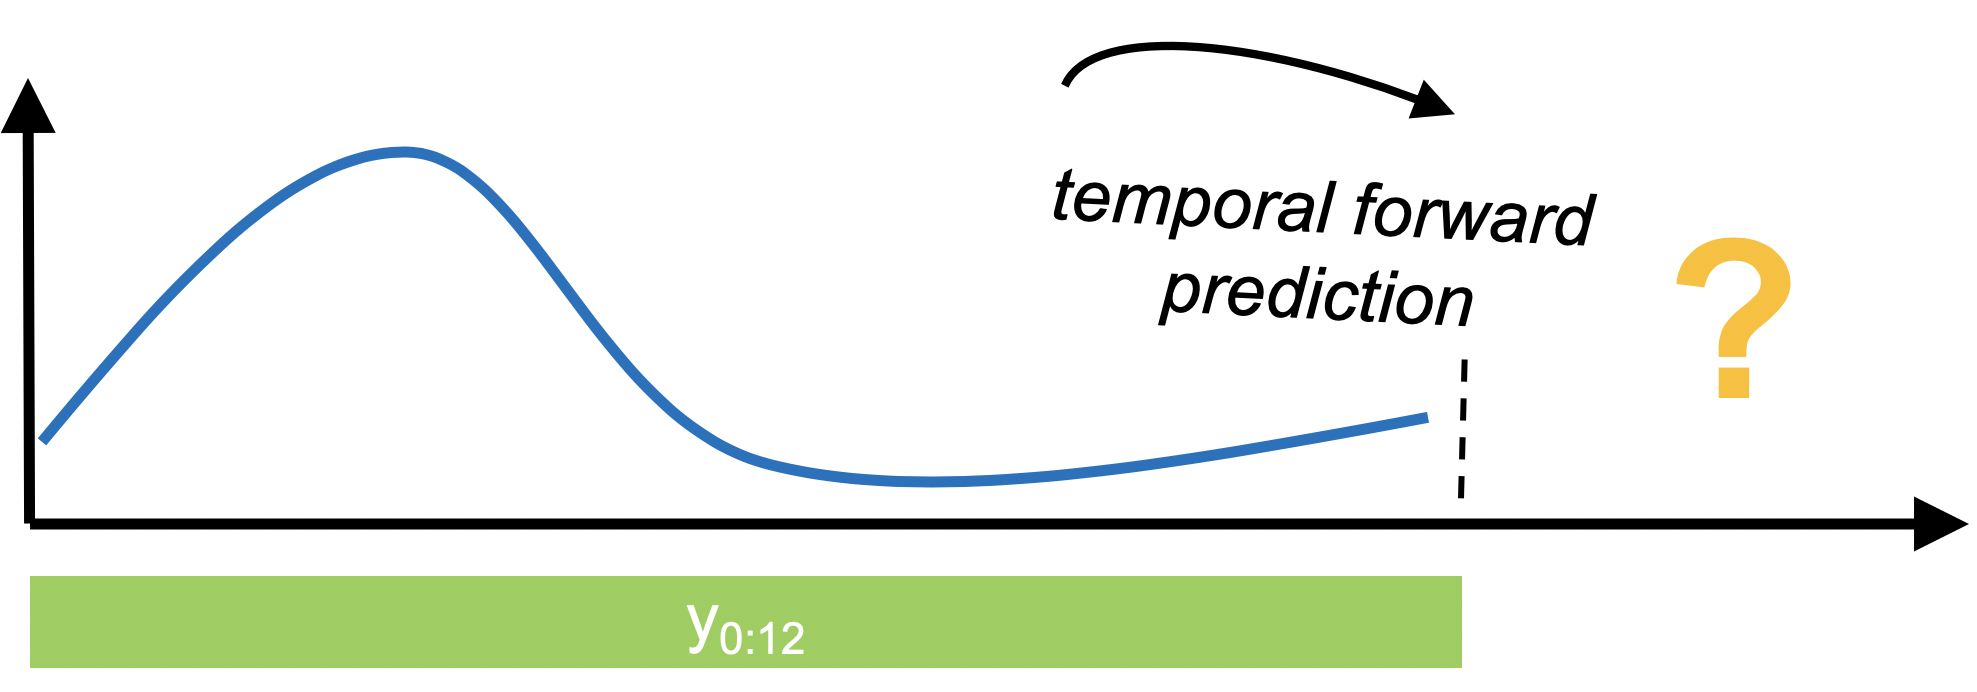

(Image source: https://www.sktime.org/en/stable/examples/01_forecasting.html.)



```
# Convert index to pd.DatetimeIndex
y = y.to_timestamp(freq="M")

y_train, y_test = temporal_train_test_split(y, test_size=36)
```





```
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split

forecaster = make_reduction(
    regressor, scitype="time-series-regressor", window_length=12
)
forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index)
y_pred = forecaster.predict(fh)
```



## Autocorrelation and stationarity

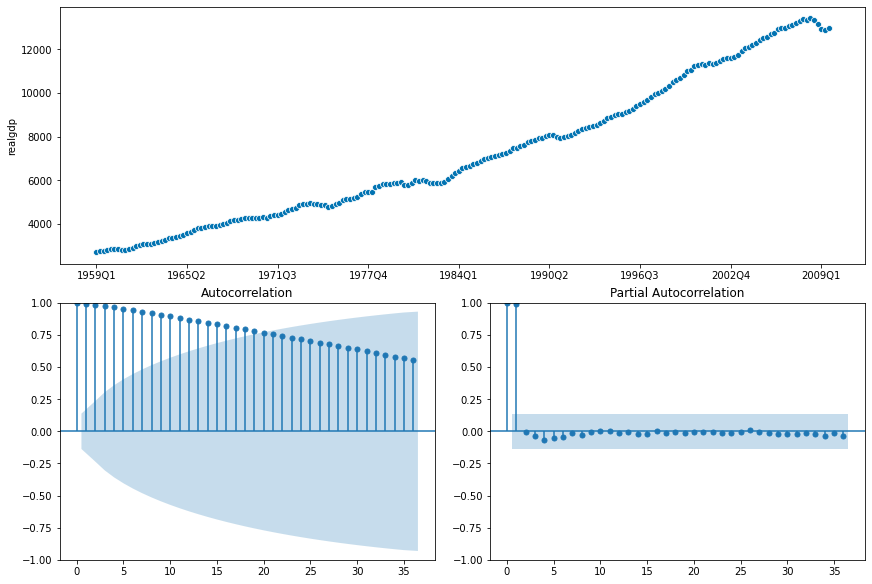

In [10]:
from sktime.utils.plotting import plot_correlations

plot_correlations(
    realgdp, lags=36, alpha=0.05, pacf_method="ywadjusted",
    acf_title="Autocorrelation", pacf_title="Partial Autocorrelation",
);

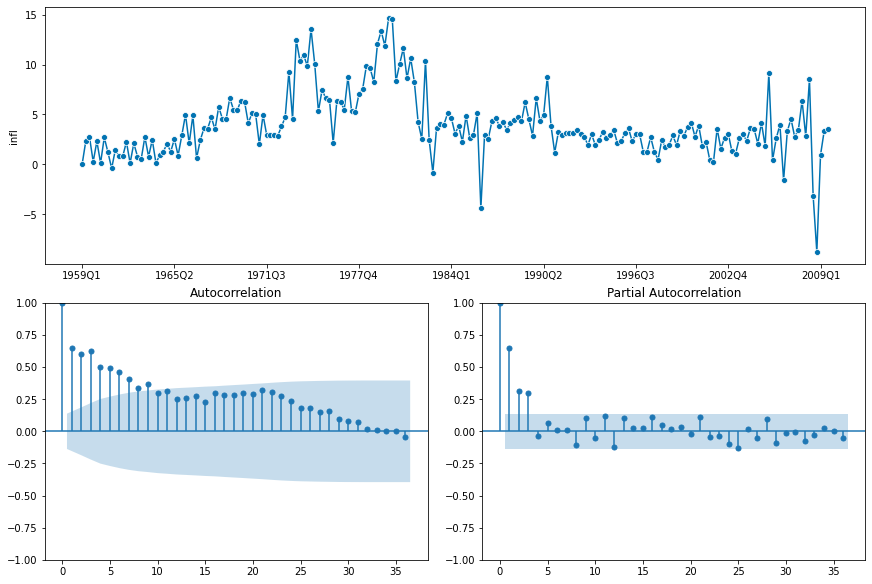

In [11]:
plot_correlations(
    infl, lags=36, alpha=0.05, pacf_method="ywadjusted",
    acf_title="Autocorrelation", pacf_title="Partial Autocorrelation",
);

## ARIMA as a strong baseline


ARIMA is an algorithm to find Autoregressive Integrated Moving-Average components and build a time series forecasting model. On its basic form, ARIMA has three main parameters to tune. How to find appropriate parameters for ARIMA (p, d, q)? The Box-Jenkins method was well-known as an approach to take the parameters from analysis on autocorrelation and stationarity.

* p -> Autoregressive components (a.k.a lags)
* d -> Integrative component (diff)
* q -> Moving average components (trend lags)

But there are lots of other subtypes of ARIMA models, such as SARIMA that takes into account seasonality and many others.

If you find ARIMA an interesting algorithm and want know more about it, there are many great videos online. Here we will use the (famously on R) `AutoARIMA` method, restricting parameters to avoid overfitting.


ARIMA info:
{'ma.L1': -0.3634460835424699, 'ar.S.L12': -0.12386440506599077, 'ar.S.L24': 0.19105747581116445, 'sigma2': 130.4479953547119, 'order': (0, 1, 1), 'seasonal_order': (2, 1, 0, 12), 'aic': 1019.1780567487451, 'aicc': 1019.4955170662055, 'bic': 1030.6788460415498, 'hqic': 1023.8513413902231}


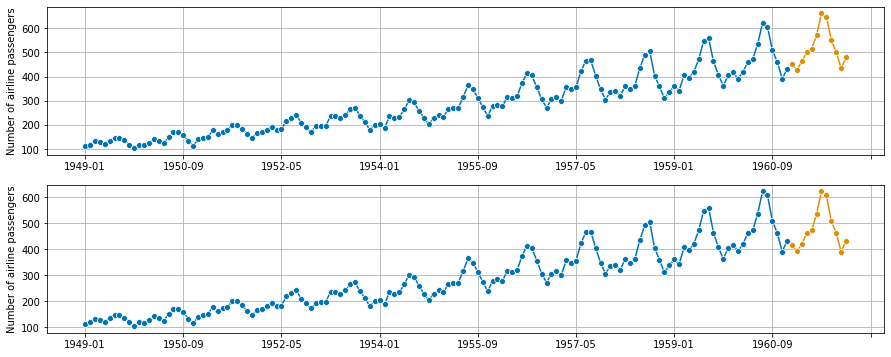

In [12]:
# AutoARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster

y = load_airline()

# ARIMA
forecaster = AutoARIMA(sp=12,
                       suppress_warnings=True)
forecaster.fit(y)
print(f"ARIMA info:\n{forecaster.get_fitted_params()}")

y_pred = forecaster.predict(fh=np.arange(1, 13)) # forecast the next 12 months at once

# vs NaiveForecaster
naive_forecaster = NaiveForecaster(strategy='last', sp=12)
naive_forecaster.fit(y)
y_pred_naive = naive_forecaster.predict(fh=np.arange(1, 13))

fig, ax = plt.subplots(nrows=2, figsize=(15,6))
ax[0].grid()
plot_series(y, y_pred, ax=ax[0])
ax[1].grid()
plot_series(y, y_pred_naive, ax=ax[1]);

### Other decision-making baselines

| Interpretation                                             | Forecaster sktime                                   |
|------------------------------------------------------------|-----------------------------------------------------|
| "Tomorrow will be just like today"                         | `NaiveForecaster(strategy='last')`                  |
| "Tomorrow will be close to the overall mean"               | `NaiveForecaster(strategy='mean')`                  |
| "Tomorrow will be the mean of the last three days"         | `NaiveForecaster(strategy='mean', window_length=3)` |
| "Next month will be as it was the same month of last year" | `NaiveForecaster(strategy='last', sp=12)`           |

## Forecast evaluation workflow in a nutshell

Train: 108 points 
Test: 36 points


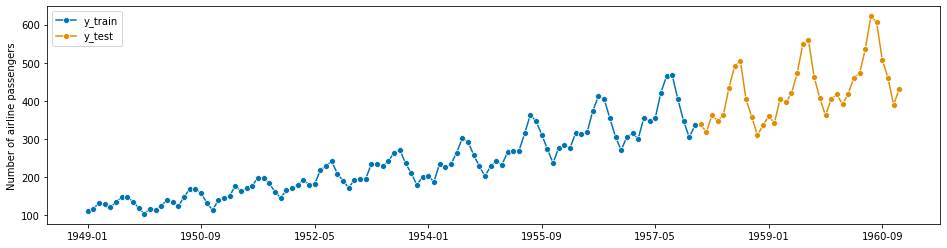

In [13]:
# Split time series in train-test correctly
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(f"Train: {y_train.shape[0]} points \nTest: {y_test.shape[0]} points")

In [14]:
# Define a forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

{'mean_squared_error': 613.662609655092, 'r2_score': 0.8997005618495348}


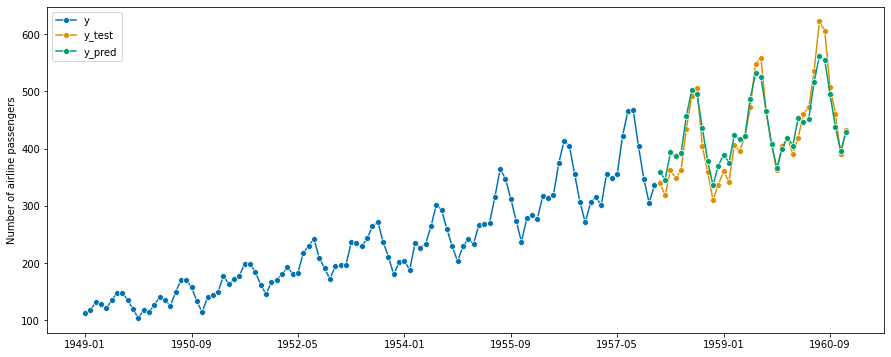

In [15]:
# Create an ensemble of predictors. Play around with the commented options if you want.

from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster, STLForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sklearn.metrics import mean_squared_error, r2_score


forecasters = [
    ("trend", STLForecaster(sp=12)), 
    # ("poly", PolynomialTrendForecaster(degree=1)),
    # ("expm", ExponentialSmoothing(trend="add")),
    # ("naive", NaiveForecaster()),
]
forecaster = AutoEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y=y_train, fh=fh)
y_pred = forecaster.predict()


# Compute performance metrics
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

# plotting
fig, ax = plt.subplots(figsize=(15,6))
plot_series(y_train, y_test, y_pred, labels=['y', 'y_test', 'y_pred'], ax=ax);

## Checking some models

{'mean_squared_error': 5418.75, 'r2_score': 0.11433812012221978}


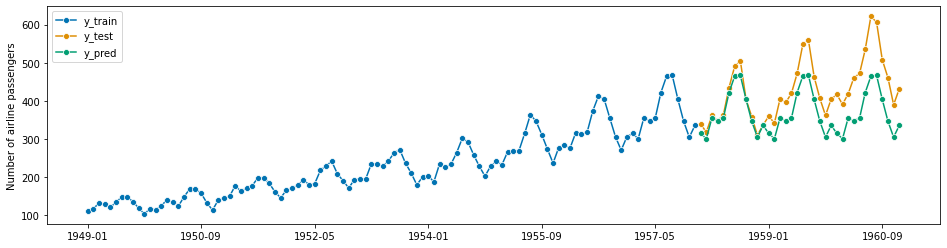

In [16]:
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

forecasters = [
    # ("trend", STLForecaster(12)),
    # ("poly", PolynomialTrendForecaster(degree=1)),
    # ("expm", ExponentialSmoothing(trend="add")),
    ("naive", NaiveForecaster(strategy="last", sp=12)),
]
forecaster = AutoEnsembleForecaster(forecasters=forecasters)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh = fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

{'mean_squared_error': 435.635055387148, 'r2_score': 0.9287980877333624}


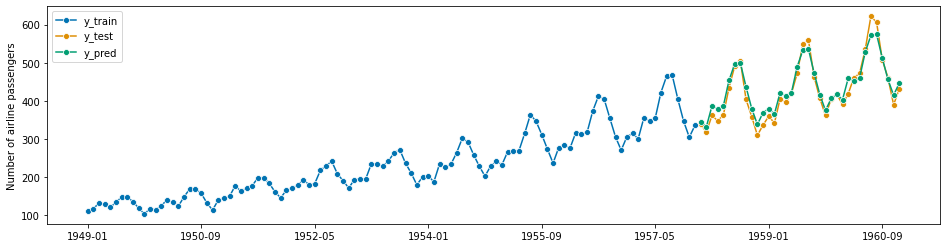

In [17]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA(
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    suppress_warnings=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh = fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

{'mean_squared_error': 489.8359037668583, 'r2_score': 0.9199392872227382}


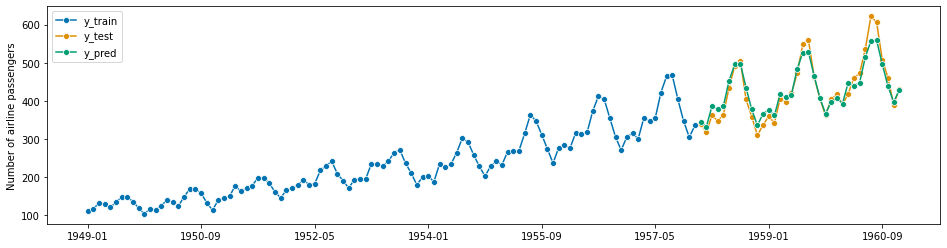

In [18]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh = fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

## Take aways

- Interpolation, Regression and Forecasting are techniques that use diferent methods to make predictions;
- Our world is chaotic thus your time series forecasting task may be more complex (multivariate, etc);
- Model evaluation is crucial, including baseline analysis;
- Validation may require the support of a domain expert that can interpret the results;
- Applications can build expert systems (agents) that use predictions to act automaticaly (predictive controllers).


## Themes for additional discussion

- Model-centric improvements: Machine learning, Deep learning, AutoML;
- Ethics, transparency, reprodutibility and interpretability;
- ...